This notebook focuses on visualizing the data that was extracted and transformed in the last notebook.

In [1]:
%matplotlib inline
from datetime import date
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='tab10')

## Read in Downloaded Data
It's assumed that the previous notebook as been run before this one in order to have a copy of the data saved locally.

In [2]:
def retrieve_data(file_name='delmarva_data.h5', series_name='lp_tidy'):
    """Pull data stored on disk or from website (and save a copy)."""
    assert series_name in ('raw', 'lp_tidy')
    if os.path.exists(file_name):
        with pd.HDFStore(file_name, mode='r') as store:
            keys = [key for key in store.keys() 
                    if key.startswith('/' + series_name)]
            key = sorted(keys, reverse=True)[0]
            print('Retrieved {} from disk.\n'.format(key[1:]))
            return store[key]

lp_tidy = retrieve_data()
lp_tidy.head(10)

Retrieved lp_tidy_20180209 from disk.



,segment,date,interpolated,hour,load,season,day,date_label,state,profile,profile_name,customer_type
0,DEDGD,2017-02-08,False,1,7.09,winter,Wednesday,Feb 08,DE,GD,General Service,Commercial
1,DEDGD,2017-02-09,False,1,8.09,winter,Thursday,Feb 09,DE,GD,General Service,Commercial
2,DEDGD,2017-02-10,False,1,9.43,winter,Friday,Feb 10,DE,GD,General Service,Commercial
3,DEDGD,2017-02-11,False,1,9.14,winter,Saturday,Feb 11,DE,GD,General Service,Commercial
4,DEDGD,2017-02-12,False,1,8.70,winter,Sunday,Feb 12,DE,GD,General Service,Commercial
5,DEDGD,2017-02-13,False,1,8.50,winter,Monday,Feb 13,DE,GD,General Service,Commercial
6,DEDGD,2017-02-14,False,1,8.76,winter,Tuesday,Feb 14,DE,GD,General Service,Commercial
7,DEDGD,2017-02-15,False,1,8.87,winter,Wednesday,Feb 15,DE,GD,General Service,Commercial
8,DEDGD,2017-02-16,False,1,9.00,winter,Thursday,Feb 16,DE,GD,General Service,Commercial
9,DEDGD,2017-02-17,False,1,9.17,winter,Friday,Feb 17,DE,GD,General Service,Commercial


### Recall: Attribute Definitions
* **hour** : Hour of the day (1 - 24).  Represents the interval ending at that number, i.e. 1 is midnight to 1 AM, 2 is 1:01 AM to 2 AM, ..., 24 is 11:00 PM to midnight of the next day.
* **day** : Weekday name (Sunday, Monday, ..., Saturday).
* **date_label** : *Month day* formatted date.
* **state** : US state (MD or DE).
* **profile** : Two character code for specific load profile.
* **profile_name** : More descriptive name for profile from utility.
* **customer_type** : Type of customer (Residential, Commercial, Other).
* **season** : Season of the year, e.g. summer (defined as Jun 16 - Sep 15).
* **interpolated** : A value that was linear interpolated.

# Exploratory Data Analysis
Looking for an overall understanding of the data and general trends.

In [3]:
def show_xlabels(facet_grid):
    """Show the x-axis labels for all plots in seaborn facet grid."""
    for ax in facet_grid.axes:
        try:
            plt.setp(ax.get_xticklabels(), visible=True)
        except AttributeError:
            for axx in ax:
                plt.setp(axx.get_xticklabels(), visible=True)

In [4]:
lp_tidy['day_type'] = np.where(lp_tidy.date.dt.dayofweek < 5, 'weekday', 'weekend')

### Subset customers

In [5]:
residential = lp_tidy.query('customer_type == "Residential"')
commercial = lp_tidy.query('customer_type == "Commercial"')
other = lp_tidy.query('customer_type == "Other"')

# How do customers use electricity throughout the day?
The cost of electricity changes by the hour, so a customer's daily usage pattern can greatly influence the cost to serve them.

### Residential

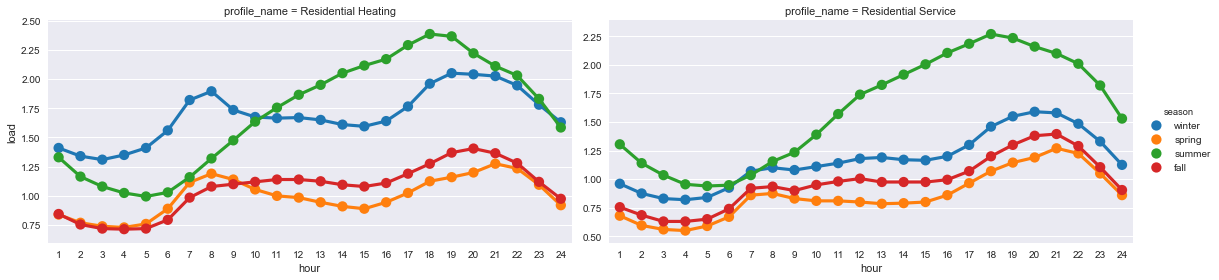

In [14]:
g = sns.factorplot(data=residential, x='hour', y='load', hue='season', kind='point',
                   col='profile_name', col_wrap=2, aspect=2, sharey=False,
                   ci=None, estimator=np.median)
show_xlabels(g)

* Residential customers generally use the most electricity around 7 - 9 AM and 8 - 10 PM in the winter and spring.
* Spring and winter are typically in line in terms of magnitude and shape, but summer usage is generally higher, especially after 7 AM.
* Residential Heating customers have higher usage during the winter than non-heating customers, which is to be expected.  The heating component refers to the fact that they use electricity to heat their homes rather than natural gas or another fuel source.

### Commercial

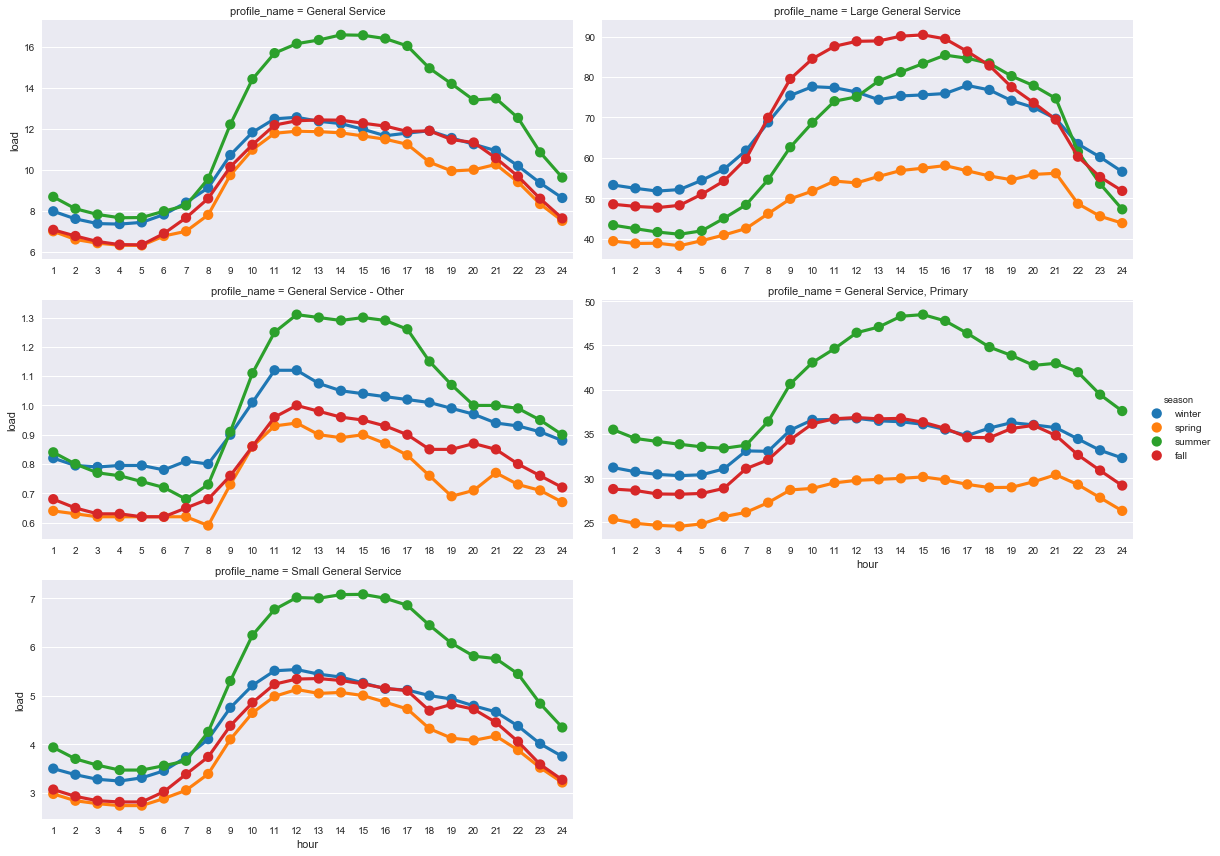

In [15]:
g = sns.factorplot(data=commercial, x='hour', y='load', hue='season', kind='point',
                   col='profile_name', col_wrap=2, aspect=2, sharey=False,
                   ci=None, estimator=np.median)
show_xlabels(g)

Since most people work from 9 to 5, this is the time of highest usage during the day.  For all profiles except Large General Service, summer usage dominates the other seasons followed by winter.  However, for those customers, the fall has the highest usage.

### Other

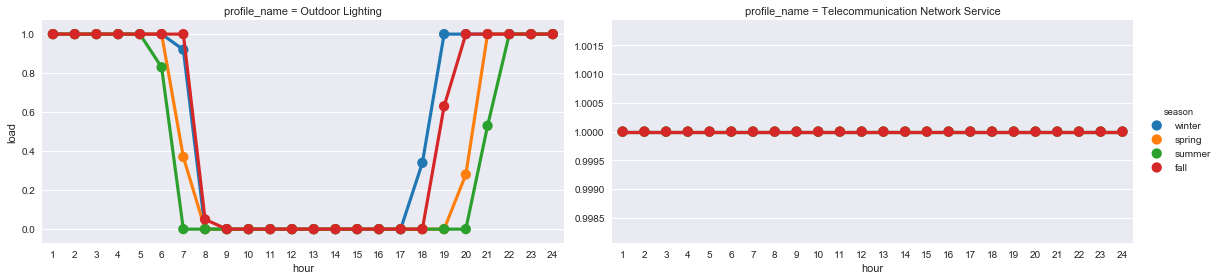

In [8]:
g = sns.factorplot(data=other, x='hour', y='load', hue='season', kind='point',
                   col='profile_name', col_wrap=2, aspect=2, sharey=False,
                   ci=None, estimator=np.median)
show_xlabels(g)

* Telecommunications Network Service customers use a constant amount of electricity 24-7.
* Outdoor Lighting usage only varies by the number of daylight hours in the day, thus only seems to change based on season.

## How does electricity usage vary by season and type of day?

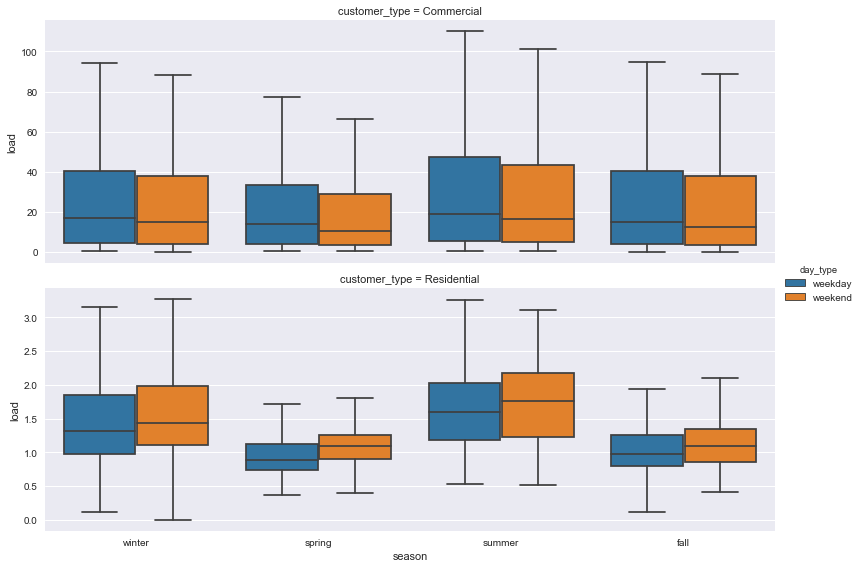

In [9]:
crit = '(customer_type == "Residential") | (customer_type == "Commercial")'
g = sns.factorplot(data=lp_tidy.query(crit), x='season', y='load', kind='box', 
                   row='customer_type', hue='day_type', aspect=2.75, 
                   sharey=False, showfliers=False)
show_xlabels(g)

* Weekday usage is generally higher for Commercial customers than Weekend usage.  Residential customers, on the other hand, usually use more energy on weekends.
* Shoulder seasons (Spring, Fall) are generally lower for Residential customers when they don't need heat or cool their homes.
* Commercial customers typically do not use much more electricity in the Summer, though the variance is much higher during that period.

## How has energy usage changed over the last year?
Plots of time series of load by week, state, and profile.

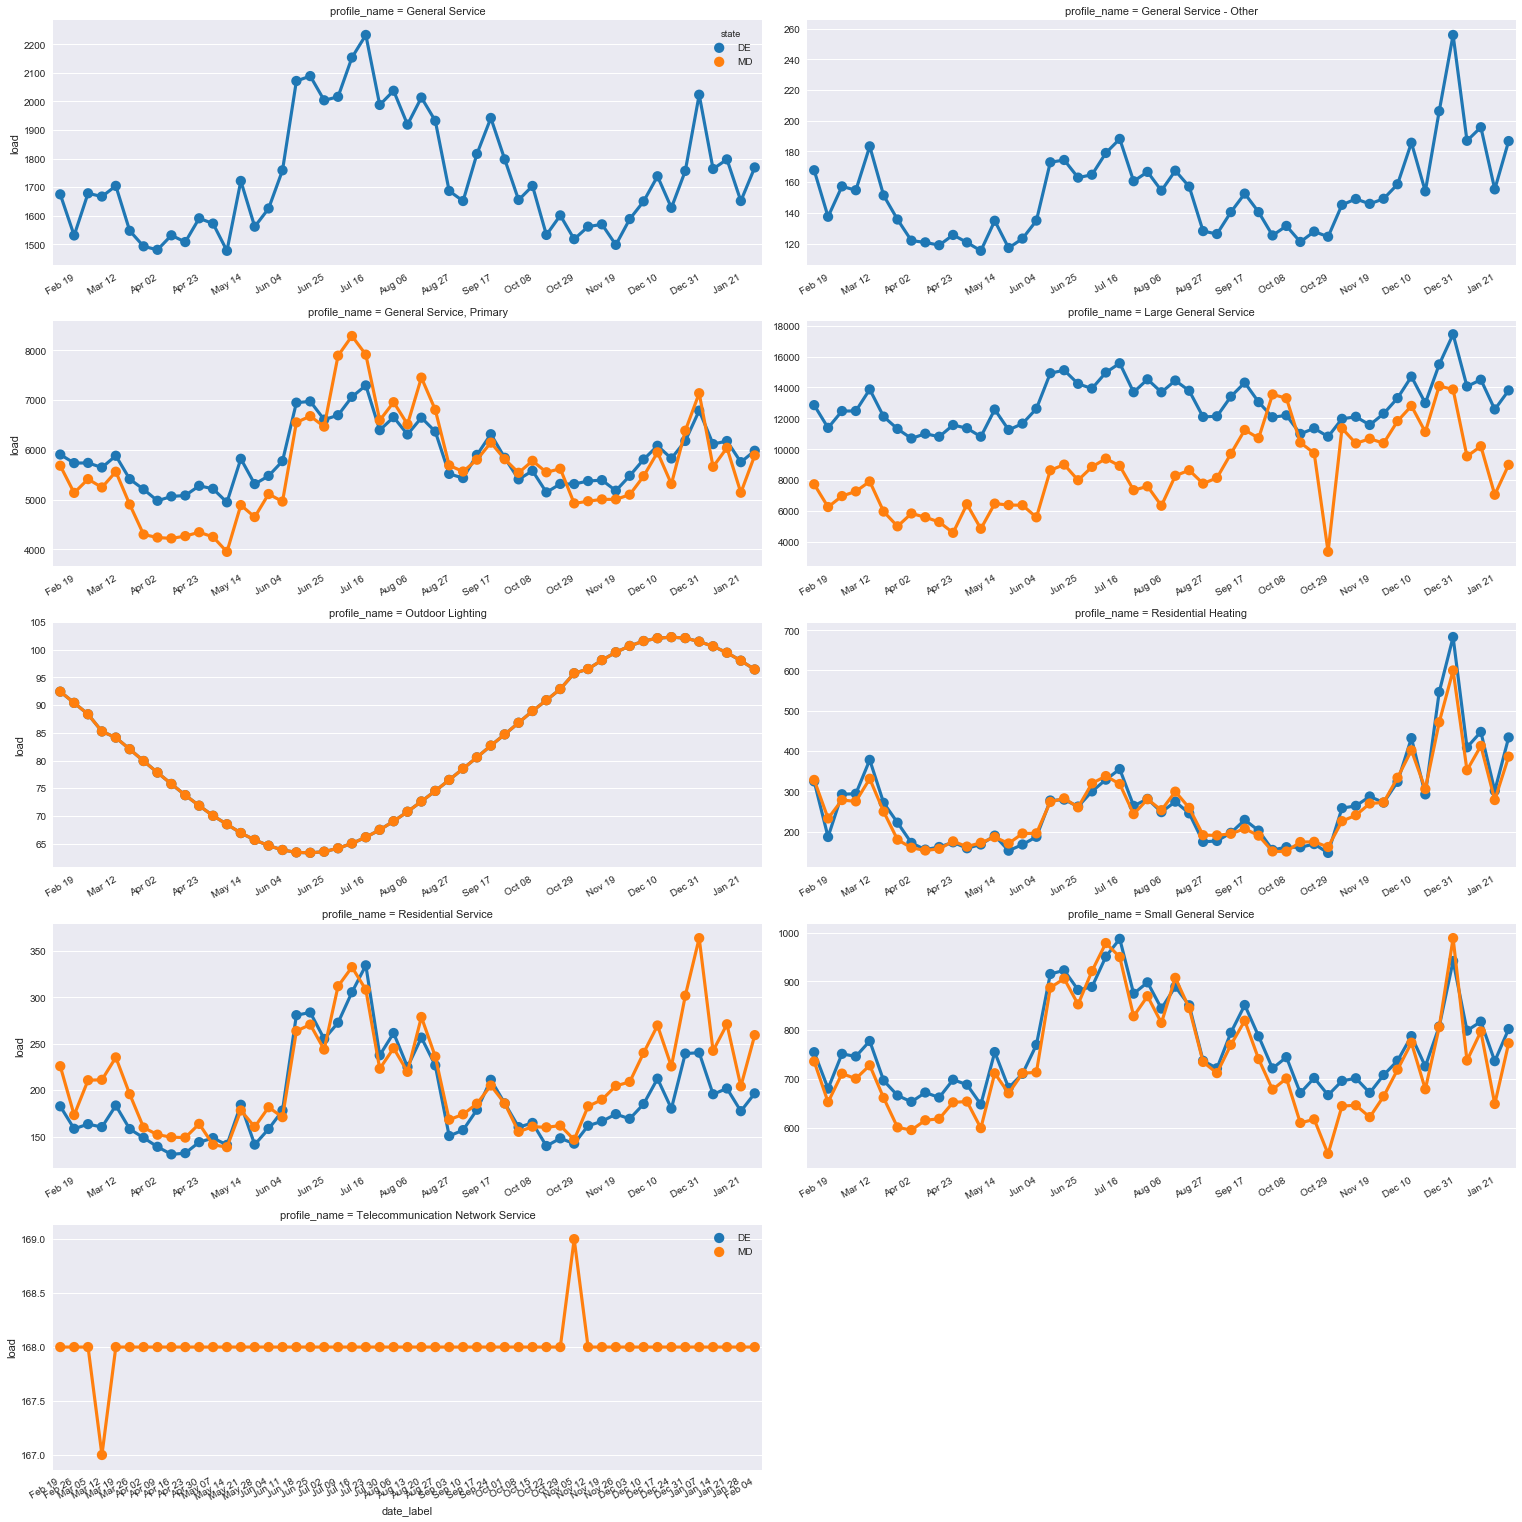

In [17]:
grouper = [pd.Grouper(freq='W'), 'state', 'profile_name']
data = lp_tidy.set_index('date').groupby(grouper)['load'].sum().sort_index()
core = [df.iloc[1:-1] for i, df in data.groupby(level=['state', 'profile_name'])]
data = (pd.concat(core)
        .reset_index()
        .assign(date_label=lambda df: df.date.dt.strftime('%b %d')))
g = sns.factorplot(x='date_label', y='load', hue='state', col='profile_name', col_wrap=2,
                   aspect=2.5, data=data, size=4.25, sharey=False, kind='point', 
                   legend=True, legend_out=False)
g.fig.autofmt_xdate()
plt.legend()
for ax in g.axes.flatten():
    plt.setp(ax.get_xticklabels()[::3], visible=True, rotation=30)
plt.tight_layout();

* Usage patterns are pretty similar between states, except for Large General Services customers.  These represent the largest consumers and likely only consist of a small set of entities.

# Why did Maryland's usage fall off a cliff at the beginning of November?

## Let's zoom out to each state's usage by day

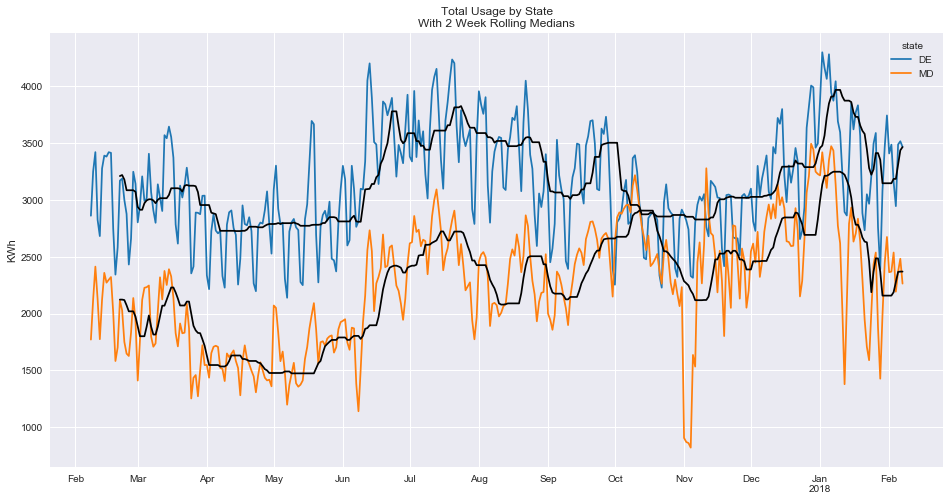

In [49]:
agg = lp_tidy.groupby(['date', 'state'])['load'].sum().unstack()
rolling = agg.rolling(14).median()
ax = agg.plot(figsize=(16, 8))
ax = rolling.plot(ax=ax, style='k-', legend=False)
plt.title('Total Usage by State\nWith 2 Week Rolling Medians')
ax.set_ylabel('KWh')
ax.set_xlabel('');

It's clear that the drop is only in Maryland and it's way below the surrounding period.  Let's dig a little deeper into Maryland...

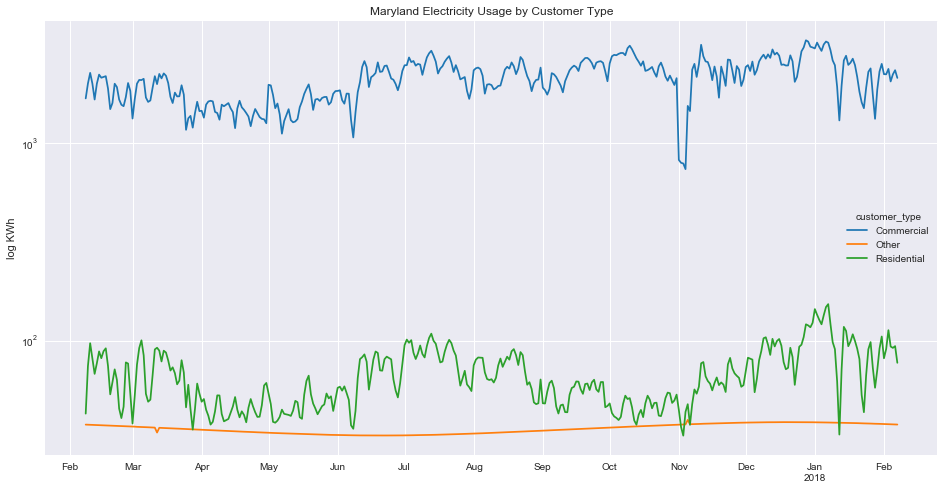

In [50]:
title = 'Maryland Electricity Usage by Customer Type'
md = lp_tidy.query('state == "MD"')
md_agg = md.groupby(['date', 'customer_type'])['load'].sum().unstack()
ax = md_agg.plot(figsize=(16, 8), logy=True, title=title)
ax.set_ylabel('log KWh')
ax.set_xlabel('');

The sharp decline is only showing up for Commercial customers.  There's corresponding decrease for Residential customers, but it looks to be within the same ballpark.  Let's see which profiles have this dip...

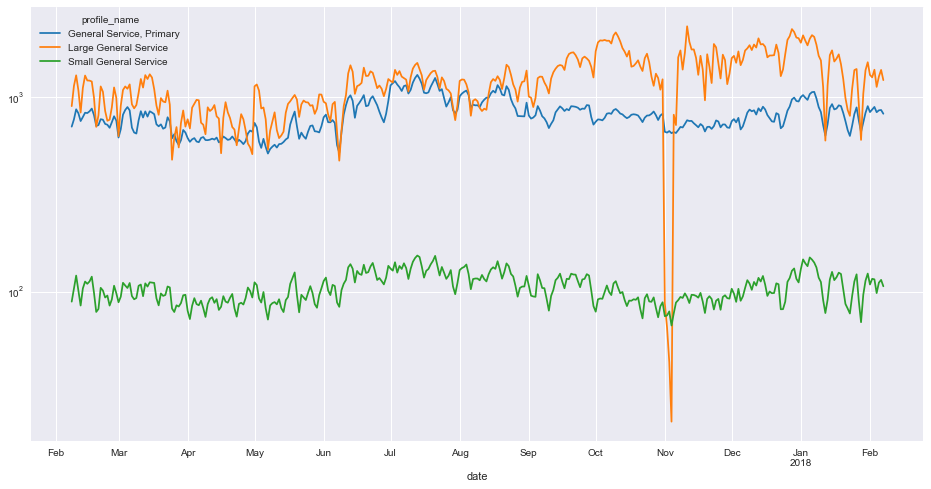

In [35]:
md_com = md.query('customer_type == "Commercial"')
md_com_agg = md_com.groupby(['date', 'profile_name'])['load'].sum().unstack()
ax = md_com_agg.plot(figsize=(16, 8), logy=True)

Now we see that Large General Service (LGS), the largest energy consumers, is the culprit.

# Check Weather Data

In [53]:
with pd.HDFStore('weighted_average_BWI_2017.h5', mode='r') as store:
    bwi = store['BWI']
bwi.head()

,AIR_TEMP_CELSIUS,TEMP_F,AIR_TEMP_DEW_PT,RELATIVE_HUMIDITY_EST,STATION,FLAVOR
DATETIME,,,,,,
2017-01-01 01:00:00,70.4,44.7,-56.0,40.20,BWI,weighted_average
2017-01-01 02:00:00,55.4,41.9,-56.0,44.56,BWI,weighted_average
2017-01-01 03:00:00,47.2,40.5,-55.4,47.53,BWI,weighted_average
2017-01-01 04:00:00,23.1,36.2,-48.9,58.99,BWI,weighted_average
2017-01-01 05:00:00,34.1,38.2,-39.5,58.60,BWI,weighted_average


#### Daily Load

count      32.000000
mean     1299.856250
std       565.114412
min        21.490000
25%      1210.387500
50%      1439.195000
75%      1627.260000
max      2308.650000
Name: load, dtype: float64


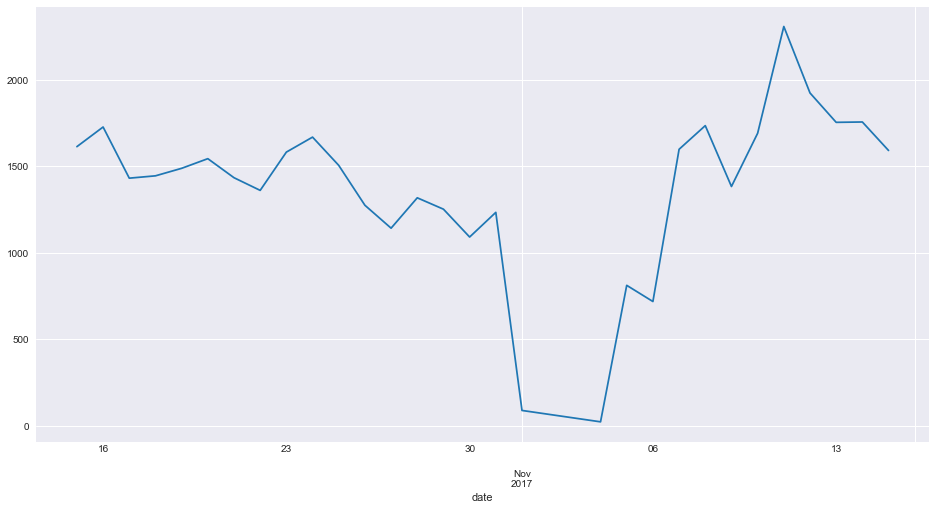

In [54]:
md_com_lgs = md_com.query('profile_name == "Large General Service"')
df = md_com_lgs.groupby('date')['load'].sum().loc['Oct 15, 17':'Nov 15, 17']
print(df.describe())
df.plot(figsize=(16, 8));

In [55]:
df[df < 1000]

date
2017-11-01     87.31
2017-11-02     65.37
2017-11-03     43.43
2017-11-04     21.49
2017-11-05    811.12
2017-11-06    717.51
Name: load, dtype: float64

#### Hourly Load

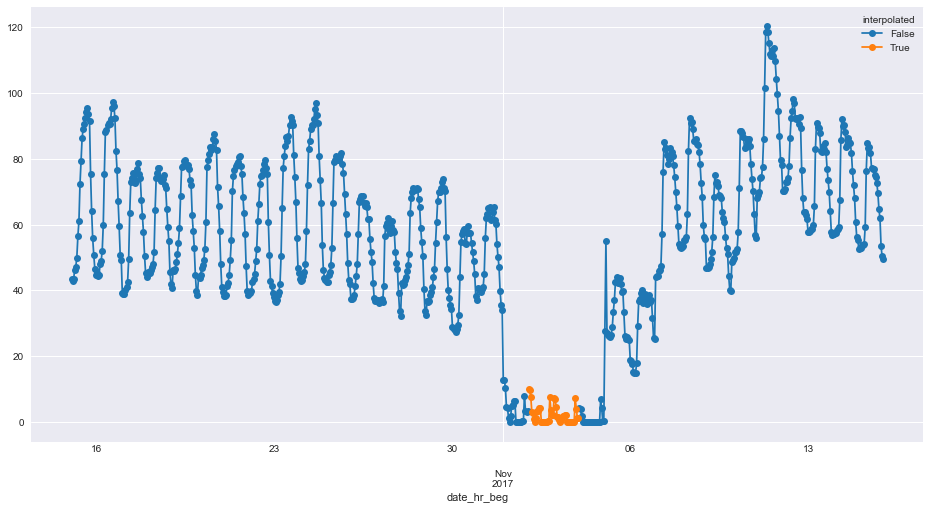

In [66]:
rng = pd.date_range('10/15/2017', '11/15/2017')
df = md_com_lgs.set_index('date').loc[rng].copy()
df['date_hr_beg'] = df.index + pd.Timedelta(1, 'h') * (df.hour - 1)
df.set_index(['date_hr_beg', 'interpolated'])['load'].unstack().plot(figsize=(16, 8), style='o-');

It looks as though the data was interpolated properly, however, the end points of Nov 1 and Nov 4 reflect a dramatic change during that time.  

In [68]:
df = df.set_index('date_hr_beg')[['load']].join(bwi)
df.head()

,load,AIR_TEMP_CELSIUS,TEMP_F,AIR_TEMP_DEW_PT,RELATIVE_HUMIDITY_EST,STATION,FLAVOR
date_hr_beg,,,,,,,
2017-10-15 00:00:00,43.40,172.00,63.00,172.00,100.0,BWI,weighted_average
2017-10-15 01:00:00,42.81,172.00,63.00,172.00,100.0,BWI,weighted_average
2017-10-15 02:00:00,43.47,172.00,63.00,172.00,100.0,BWI,weighted_average
2017-10-15 03:00:00,46.24,172.00,63.00,172.00,100.0,BWI,weighted_average
2017-10-15 04:00:00,47.08,172.73,63.12,172.73,100.0,BWI,weighted_average


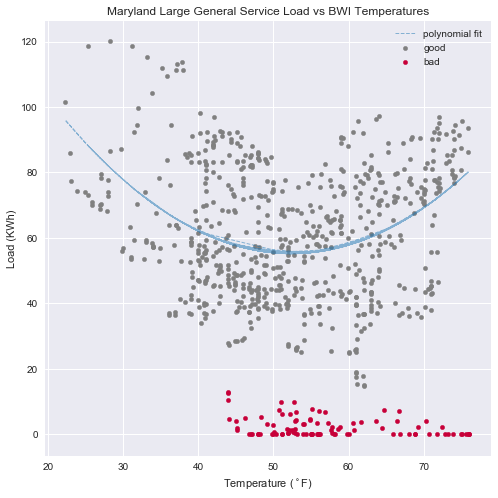

In [93]:
idx = df.loc['11/1/2017':'11/4/2017'].index
not_idx = df.index.difference(idx)

coefs = np.polyfit(x=df.loc[not_idx, 'TEMP_F'], y=df.loc[not_idx, 'load'], deg=2)
X = np.array([df.loc[not_idx, 'TEMP_F']**2, df.loc[not_idx, 'TEMP_F'], np.ones(not_idx.size)])
fit = np.dot(X.T, coefs)

fig, ax = plt.subplots(figsize=(8, 8))
for i, label, c in [(not_idx, 'good', 'gray'), (idx, 'bad', '#C70039')]:
    df.loc[i].plot.scatter(x='TEMP_F', y='load', ax=ax, c=c, label=label, legend=True);
ax.plot(df.loc[not_idx, 'TEMP_F'], fit, label='polynomial fit', lw=1, ls='--', alpha=.5)
ax.legend()
plt.title('Maryland Large General Service Load vs BWI Temperatures')
ax.set_xlabel('Temperature ($^\circ$F)')
ax.set_ylabel('Load (KWh)');

We can rule out the effect of temperature - electricity usage is far below the norm and does not appear to vary with temperature like the rest of the data.